In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

In [2]:
import sys
sys.path.append('../../..')

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json

from magrec.prop.Fourier import FourierTransform2d
from magrec.prop.Kernel import HarmonicFunctionComponentsKernel, MagnetizationFourierKernel2d
from magrec.misc.plot import plot_n_components
from magrec.prop.Propagator import FourierPadder, MagnetizationPropagator2d
from magrec.misc.load import load_matlab_data



import magrec.prop.constants as constants

from magrec import __datapath__

ModuleNotFoundError: No module named 'magrec'

: 

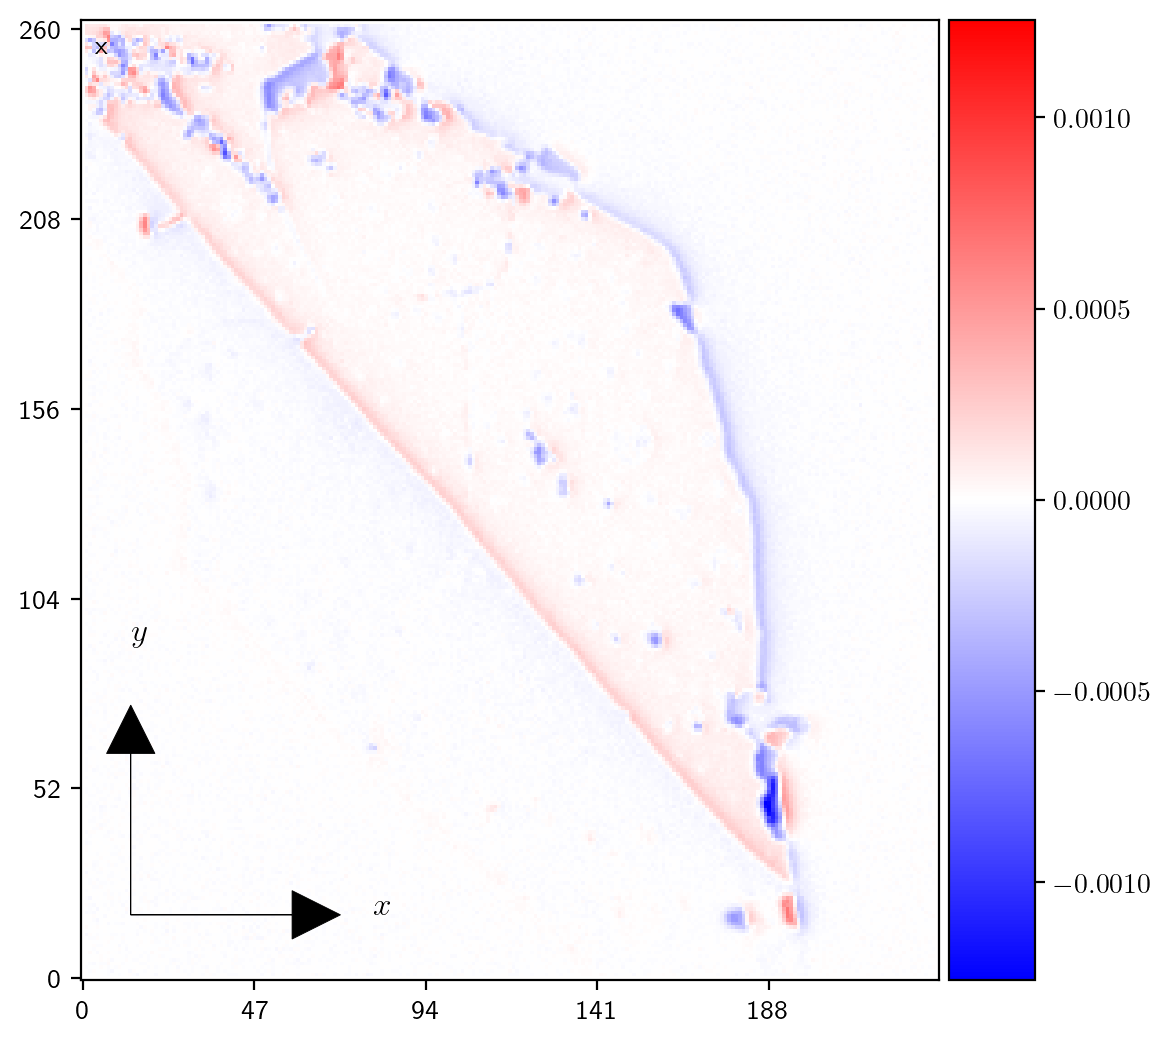

In [4]:
f = open(__datapath__ / "Magnetisation out of plane" / "CrI3_Exp_B_20180525_001.json")
data = json.load(f)

BNV = data["ExperimentMagneticField"]['BNV']["Data"]
B_NV = torch.from_numpy(np.array(BNV))


sensor_theta = data["ExperimentMagneticField"]['BNV']['Theta']
sensor_phi = data["ExperimentMagneticField"]['BNV']['Phi'] - 90 

Bpad = FourierPadder.pad_2d(B_NV, (1,1), 'linear_ramp')
plot_n_components(Bpad, symmetric=True, cmap="bwr")

In [5]:
# data from inspecting the matlab file  
dx=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] *1e6  # in μm
dy=data['ExperimentMagneticField']['MagnetisationPropagation']['PropStruct']['PixelSizeX'] * 1e6


ft = FourierTransform2d(Bpad.shape, dx=dx, dy=dy)
kernel = HarmonicFunctionComponentsKernel.define_kernel_matrix(ft.kx_vector, ft.ky_vector, theta=sensor_theta, phi=sensor_phi)

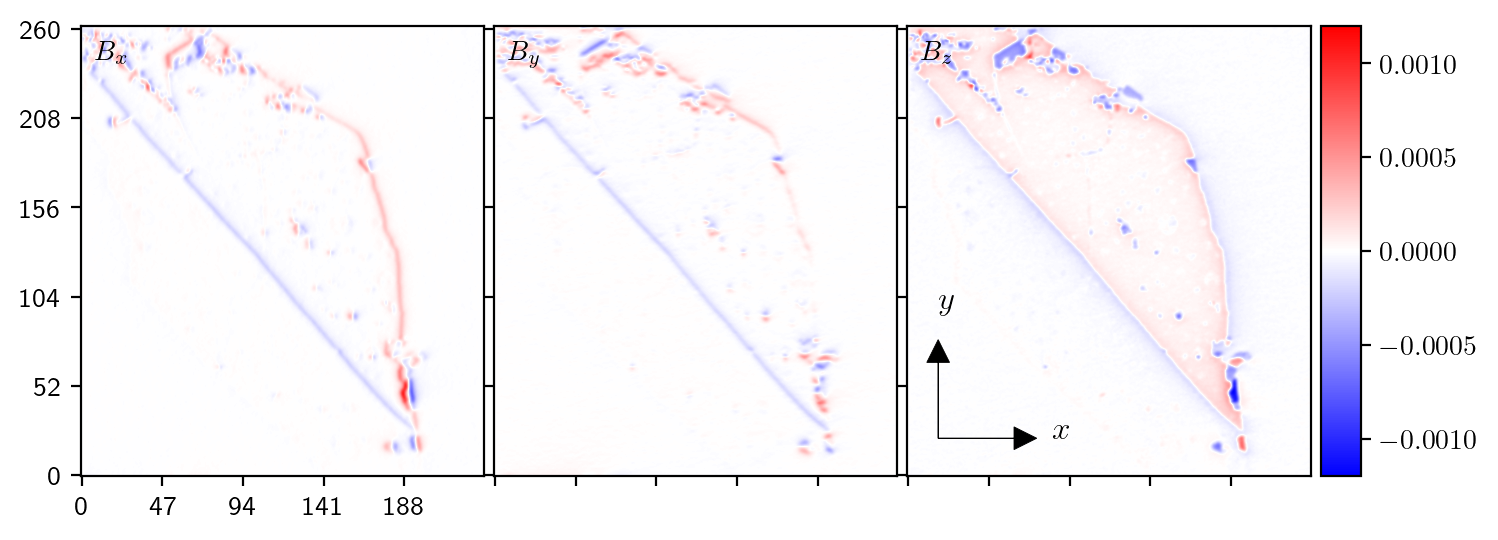

In [6]:
b_NV = ft.forward(Bpad, dim=(-2, -1))
b = torch.einsum("jkl,kl-> jkl", kernel, b_NV)
Bharmonic = ft.backward(b, dim=(-2, -1))
plot_n_components(Bharmonic, symmetric=True, labels=[r"$B_x$", r"$B_y$", r"$B_z$"], cmap="bwr", 
imshow_kwargs={"interpolation": "bicubic"})

# Reconstruct the out of plane magnetisation using BNV

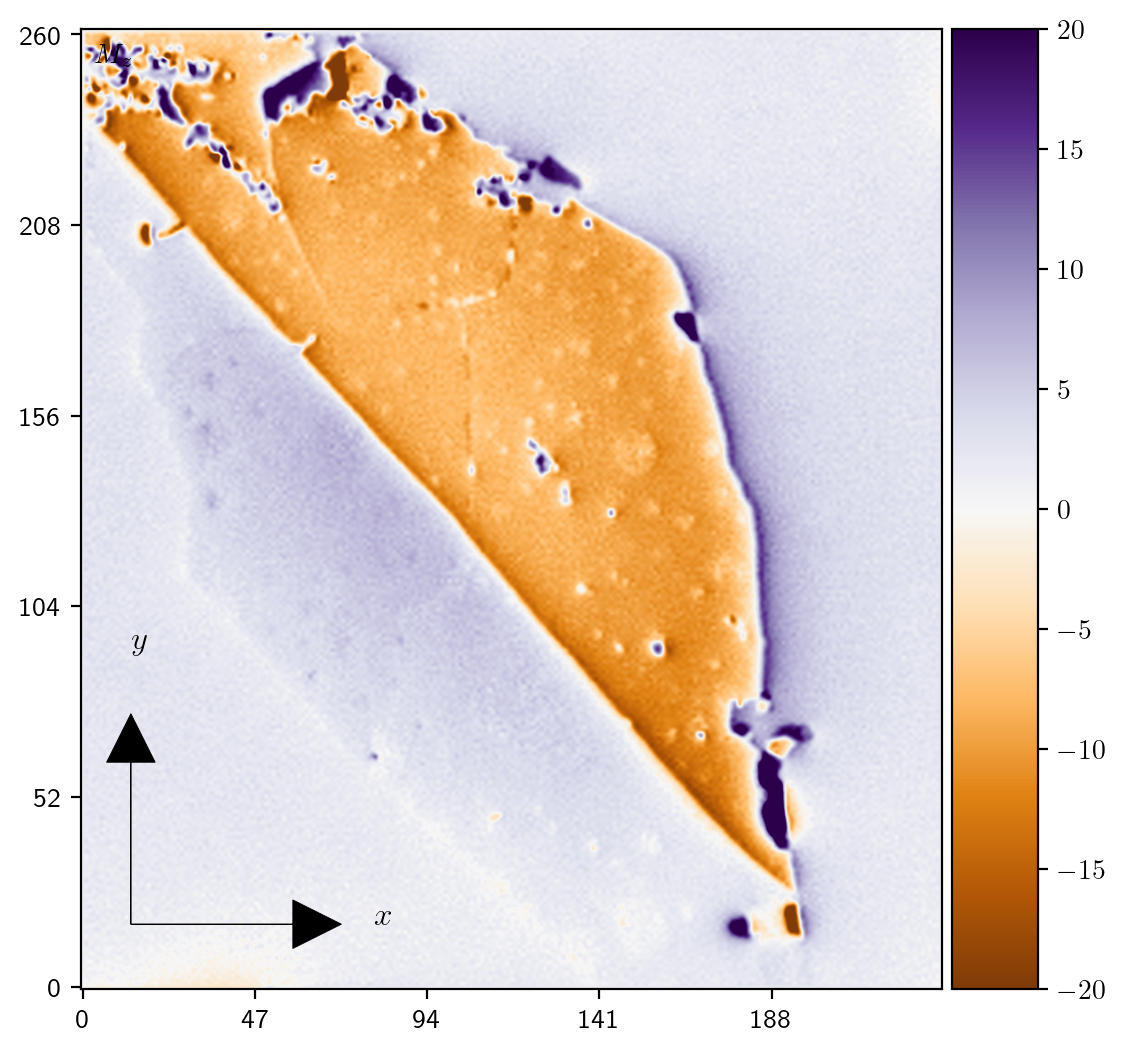

In [27]:
height = 0.06 # in μm
layer_thickness = 0
MagProp = MagnetizationPropagator2d(Bpad.shape, dx, dy, height, layer_thickness)
Mag = MagProp.M_from_B(Bpad, magnetisation_theta=0, magnetisation_phi=0, sensor_theta=sensor_theta, sensor_phi=sensor_phi)

plot_n_components(Mag*constants.convert_AperM2_to_ubpernm2, 
    symmetric=True, 
    labels=[r"$M_z$"], 
    cmap="PuOr", 
    climits = (-20,20),
    imshow_kwargs={"interpolation": "bicubic"})


# Reconstruct the out of plane magnetisation using only the reconstructed Bz

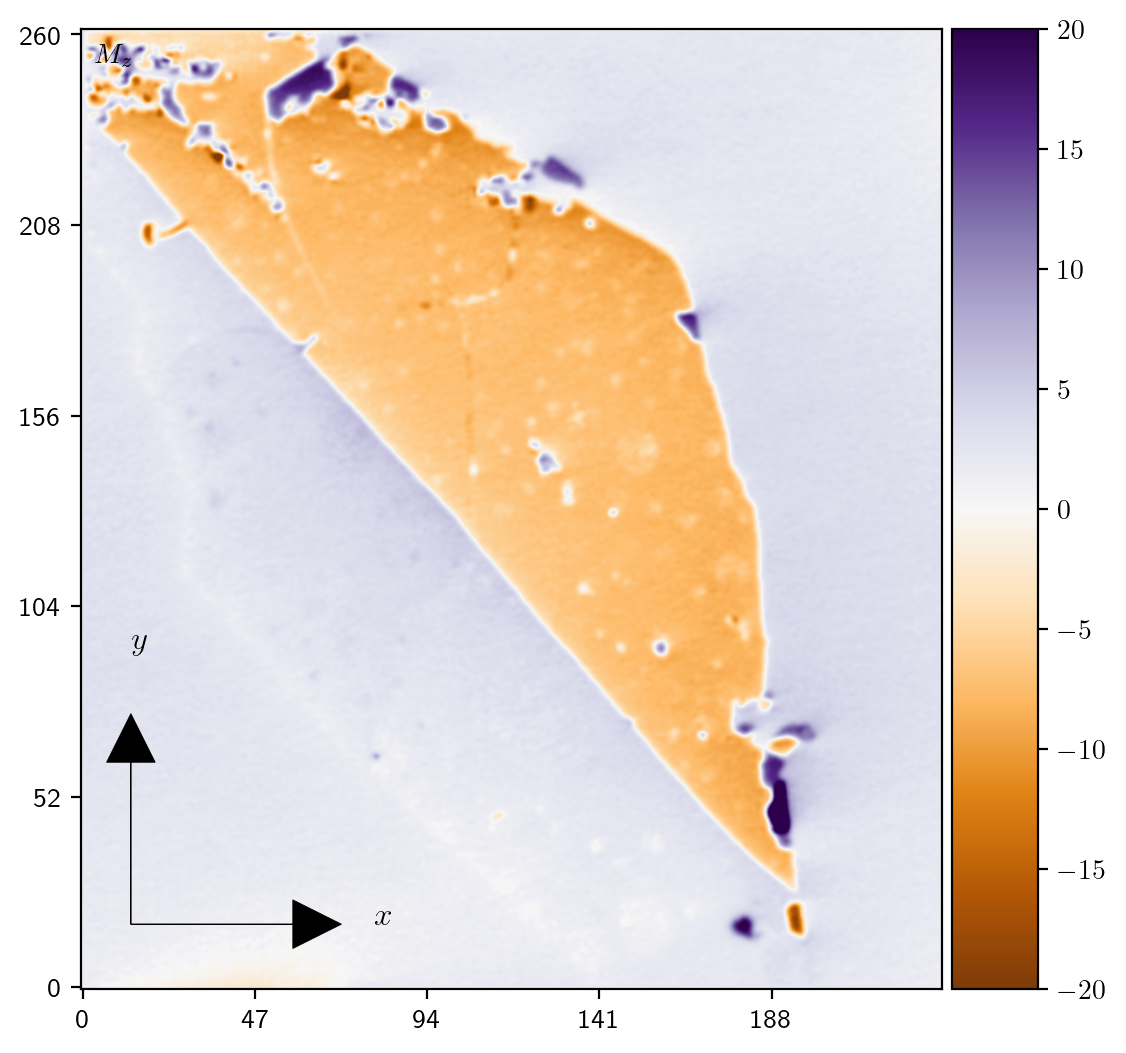

In [34]:
MagProp = MagnetizationPropagator2d(Bharmonic[2,:,:].shape, dx, dy, height, layer_thickness)
MagProp.add_hanning_filter(HanningWavelength = height)
Mag = MagProp.M_from_B(Bharmonic[2,:,:], magnetisation_theta=0, magnetisation_phi=0, sensor_theta=0, sensor_phi=0)


plot_n_components(Mag*constants.convert_AperM2_to_ubpernm2, 
    symmetric=True, 
    labels=[r"$M_z$"], 
    cmap="PuOr", 
    climits = (-20,20),
    imshow_kwargs={"interpolation": "bicubic"})

## Background substraction